In [1]:
library("TSP")
concorde_path("~/concorde/TSP")




dataETSP <- read_TSPLIB("/home/LC/mailo01/TSP-ML-Approach/src/R/CLUSTER_DIV/vm22775.tsp")


found: concorde concorde.c concorde.o 


In [3]:
concorde_result <- 569288

In [4]:
#function library

dist_pts <- function(pt1,pt2){
        return(sqrt((pt1[[1]]-pt2[[1]])^2 + (pt1[[2]]-pt2[[2]])^2))
}

angle <- function(x,y){
  dot.prod <- x%*%y 
  norm.x <- norm(x,type="2")
  norm.y <- norm(y,type="2")
  theta <- acos(dot.prod / (norm.x * norm.y))
  as.numeric(theta)
}

angle_pts <- function(pt1,pt2){
    
    if (pt1[[2]] -pt2[[2]] == 0){
        if (pt1[[1]] -pt2[[1]]>0){
            return(pi/2)
        }
        if (pt1[[1]] -pt2[[1]]<0){
            return(-pi/2)
        }
        if (pt1[[1]] -pt2[[1]]==0){
            return(0)
        }
    } else{
        x<- pt1[[1]] -pt2[[1]]
        y <-pt1[[2]] -pt2[[2]]
        angle <- atan((y)/(x))
        if (x < 0 & y>0){
            angle <- pi + angle
        }
        if (x >0 & y <0){
            angle <-2*pi +angle
        }
        if (x < 0 & y<0){
            angle <- pi + angle
        }
        return(angle)
        }
}


get_item <- function(item_to_get, database){
    counter <-1
    cont <- TRUE 
    while (counter <= length(database) & cont == TRUE){
        data_pt <-database[[counter]]
        if (data_pt[1] == item_to_get){
            return(data_pt)
            cont <- FALSE
        }
        counter <- counter +1
    }
}

get_pts_range_hor<- function(lower_bound, higher_bound, database){
    cont = TRUE
    counter <-1
    eligible_vertices <-list()
    while (counter <= length(database) & cont ==TRUE){
        value <- database[[counter]]
        
        if (value[[2]] >= lower_bound & value[[2]]<= higher_bound){
            eligible_vertices <- append(eligible_vertices, value[[1]])
        }
        if (value[[2]]> higher_bound){
            cont <- FALSE
        }
        counter <- counter +1
    }
    return(eligible_vertices)
}


get_pts_range_vert<- function(lower_bound, higher_bound, database){
    cont = TRUE
    counter <-1
    eligible_vertices <-list()
    while (counter <= length(database) & cont ==TRUE){
        value <- database[[counter]]
        
        if (value[[3]] >= lower_bound & value[[3]]<= higher_bound){
            eligible_vertices <- append(eligible_vertices, value[[1]])
        }
        if (value[[3]]> higher_bound){
            cont <- FALSE
        }
        counter <- counter +1
    }
    return(eligible_vertices)
}


get_possible_pts <- function(x_current,y_current,radius, horizontal_based, vertical_based, done){
    horizontal_eligible <- get_pts_range_hor(x_current - 2*radius, x_current + 2*radius, horizontal_based)
    vertical_eligible <- get_pts_range_vert(y_current - 2*radius, y_current + 2*radius, vertical_based)

    
    eligible <- intersect(horizontal_eligible, vertical_eligible)
    eligible<- eligible[!eligible %in% done]
    
    return(eligible)
}


add_data_mat <- function(cluster1_pos,cluster2_pos,value, mat){
    position1 <- (cluster1_pos -1)*nrow(mat) + cluster2_pos
    position2 <- (cluster2_pos -1)*nrow(mat) + cluster1_pos
    mat[[position1]] <- value
    mat[[position2]] <- value
    return(mat)
}


choose_new_edge <- function(forward_edge, backward_edge, main){

    f_vertex <- forward_edge[[2]]
    b_vertex <- backward_edge[[1]]
    
    common <- forward_edge[[1]]
    compare <- current_tree[[main]]
    
    f_min <- Inf
    f_replace <- NULL
    b_min <- Inf
    b_replace <- NULL
    
    vPt_f <-values(pointSet, keys=f_vertex) 
    vPt_b <-values(pointSet, keys=b_vertex) 
    
    
    for (vertex in compare){
        vPt_c <-values(pointSet, keys =vertex)
        if (vertex != common){
            
            if (f_min == Inf){
                f_min <- dist_pts(vPt_f , vPt_c)
                b_min <- dist_pts(vPt_b, vPt_c)
                f_replace<-vertex
                b_replace<-vertex
                
                
            } else {
                dist_f <-dist_pts(vPt_f , vPt_c) 
                if (dist_f < f_min){
                    f_min <- dist_f
                    f_replace <- vertex
                } 
                
                dist_b <- dist_pts(vPt_b , vPt_c)
                if (dist_b < b_min){
                    b_min <- dist_b
                    b_replace <- vertex
                }
            }  
        }
    }
    
    if (f_min <= b_min){
        return(list("f", f_replace))
    } else {
        return(list("b", b_replace))
    }
    
}

end_points_det <- function(cluster_tour, connections){
    merge <- hash()
    for (pt_index in 1:length(cluster_tour)){
        main <-cluster_tour[[pt_index]]
        
        if (pt_index == length(cluster_tour)){
            forward <- cluster_tour[[1]]
            backward <- cluster_tour[[pt_index - 1]]
            
        } else {
            if (pt_index == 1){
                forward <- cluster_tour[[pt_index+1]]
                backward <- cluster_tour[[length(cluster_tour)]]

                
            } else {
                forward <- cluster_tour[[pt_index+1]]
                backward <-cluster_tour[[pt_index-1]]

                }
        }
        forward_edge <- connections[[sprintf("%s-%s",main, forward)]]
        backward_edge <- connections[[sprintf("%s-%s",backward, main)]]
        
        if (forward_edge[[1]] == backward_edge[[2]]){
            if (length(current_tree[[main]]) != 1){
                compare_result <-  choose_new_edge(forward_edge, backward_edge, main)
                if (compare_result[[1]] == "f"){
                    forward_edge[[1]] <- compare_result[[2]]
                    
                } else {
                    backward_edge[[2]] <- compare_result[[2]]
                } 
            }
        } 
        merge[[toString(main)]] <-list(backward_edge[[2]],forward_edge[[1]] )
     
    }
    return(merge)
}

add_end_points <- function(tsp, end_points){
    constant <- rep(c(Inf), nrow(as.matrix(tsp)) )
    constant[[end_points[[1]]]] <- 0
    constant[[end_points[[2]]]] <- 0
    tsp <-insert_dummy(tsp, 1, const =constant, inf = Inf, label = "dummy")
    return(tsp)
}


to_global <- function(tour_list, main){
        
        for (tour_index in 1:length(tour_list)){
                for (vertex_index in 1:length(tour_list[[tour_index]])){
                        vertex <- as.integer(tour_list[[tour_index]][vertex_index])
                       
                        tour_list[[tour_index]][vertex_index] <- main[[tour_index]][vertex]
                }
        }
        return(tour_list)
}

filter_before_merge <- function(tour_list, end_points_list){
    for (index in 1:length(tour_list)){
        sol <- tour_list[[index]]
        sol <- sol [lengths(sol) != 0]
        old <- length(sol)
        start <- end_points_list[[toString(index)]][[1]]
        end <- end_points_list[[toString(index)]][[2]]
        start_pos <- match(start, sol)
        end_pos <- match(end, sol)

        if (start_pos < end_pos){
            if (start_pos != 1 | end_pos != length(sol)){
                sol <- append(rev(sol[1:start_pos]), rev(sol[end_pos:length(sol)]))
            } 
            
        } else {
            if (start_pos == length(sol) & end_pos == 1){
                sol <- rev(sol)
            } else {
                sol <- append(rev(sol[1:end_pos]), rev(sol[start_pos:length(sol)]))
                sol <- rev(sol)
             }
        }

        if(old != length(sol)){
            print("length mismatch, error occured in formatting")
            print("number of missing elements")
            print(old - length(sol))
        }
        
        tour_list[[index]] <- sol
    }
    return(tour_list)
} 

merge_all <- function(formatted_all_subtours, cluster_tour){
    merged_tour <- list()
    for (branch in cluster_tour){
        merged_tour <- append(merged_tour, all_subtours[[branch]])
    }
    print(as.integer(merged_tour))
    return(as.integer(merged_tour))
}


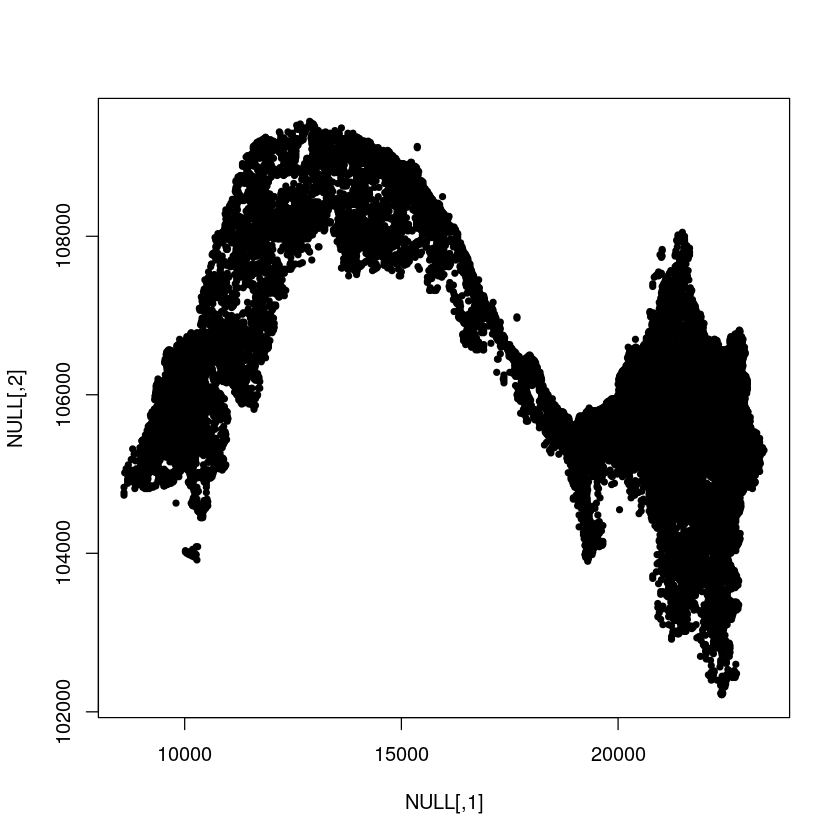

In [6]:
library("hash")
library("sets")

pointSet <- hash()
noPts <- length(dataETSP)/2
horizontal_based <- list()
vertical_based <-list()


radius <- 15
plot(dataETSP, pch=20)
symbols(dataETSP, circles=rep(radius,noPts), add=T, inches=F)

In [ ]:
print("preparing necessary data")
start_time <- Sys.time()
for (i in 1:noPts){
    pointSet[[toString(i)]] <- tuple(dataETSP[i], dataETSP[i+noPts])
    element <- list(i, dataETSP[[i]],dataETSP[[i+noPts]])
    horizontal_based <- append( horizontal_based, list(element))
    vertical_based <- append(vertical_based, list(element))
}

horizontal_based <- horizontal_based[order(sapply(horizontal_based, '[[', 2))]
vertical_based <- vertical_based[order(sapply(vertical_based,'[[',3))]
vertices_mat <- as.matrix(as.TSP(dataETSP))
done <- list 
current_tree <- list()
checklist <-(c(1:noPts))


end_time <-Sys.time()
print("total time to pre process data")
add<- end_time - start_time
total<-  add
print(add)
print("begin clustering vertices based on given radius")
start_time <- Sys.time()
while (length(checklist) != 0){

    branch <- list()

    old_branch_len<- length(branch)

    startPt = checklist[1]
    branch<-append(branch, startPt)
    done <- append(done, startPt)

    counter =1

    while(old_branch_len != length(branch)){

        current_branch_len <- length(branch)

        start <-old_branch_len+1
        pts_to_connect <- c(branch[start:current_branch_len])

        checklist <-checklist[!checklist %in% pts_to_connect]

        old_branch_len= current_branch_len

        for (connect_pt in pts_to_connect){
            vPt1 <-values(pointSet, keys=connect_pt) 
            possible_connect <- get_possible_pts(vPt1[[1]],vPt1[[2]], radius, horizontal_based,vertical_based, done)

            for (comparePt in possible_connect){

                if (!comparePt %in%branch){

                    vPt2 <-values(pointSet, keys=comparePt) 

                    if (dist_pts(vPt1,vPt2) <= 2*radius){

                        branch<-append(branch,comparePt)
                        done <- append(done,comparePt)
                        checklist <-checklist[!checklist %in% c(comparePt)]


                    } 
                } 
            }
        }
        counter <- counter +1

    }
    current_tree <- append(current_tree, list(branch))
}
end_time <- Sys.time()

print("finished clustering. Total processing time: ")
add<- end_time - start_time
total<- total + add
print(add)


branch_no <- length(current_tree)
print("number of branches in tree")
print(branch_no)
if (branch_no <= 2){
    print("number of clusters smaller or equal 2. Concorde Solver will halt")
    cont <- FALSE
} else {
    print("generating new tsp instances")
    start_time <- Sys.time()
    cluster_mat <- matrix(rep(0,branch_no^2),nrow=branch_no)

    #for each branch, need to find the shortest distance 
    #remember, have to put points already taken out of consideration

    connections <- hash()

    for (branch_index in 1:branch_no){
        #other branches to be compared to
            for (branch_compare_ind in 1:length(current_tree)){
                if (has.key(sprintf("%s-%s",branch_index,branch_compare_ind),connections) == FALSE){

                if (branch_index != branch_compare_ind){
                    minimum_dist <- Inf
                    connect_pts <- NULL

                    for (vertex in current_tree[[branch_index]]){
                        
                        for (vertex_compare in current_tree[[branch_compare_ind]]){
                            if (minimum_dist == Inf){
                                minimum_dist <- vertices_mat[vertex, vertex_compare]
                                connect_pts <- list(vertex, vertex_compare)
                            } else{
                                distance <- vertices_mat[vertex, vertex_compare]
                                if (distance <= minimum_dist){
                                    minimum_dist <- distance
                                    connect_pts <- list(vertex, vertex_compare)
                                } 
                            }
                        } 
                    }

                    connections[[sprintf("%s-%s",branch_index,branch_compare_ind)]] <-  tuple(connect_pts[[1]],connect_pts[[2]])
                    connections[[sprintf("%s-%s",branch_compare_ind,branch_index)]] <-  tuple(connect_pts[[2]],connect_pts[[1]])
                    #append distances to matrix
                    cluster_mat <- add_data_mat(branch_index,branch_compare_ind,minimum_dist, cluster_mat)

                }
            }
        }
    }
    tsp_cluster <- as.TSP(cluster_mat)
    end_time <- Sys.time()
    
    print("cluster TSP generated. Total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    print("solving the cluster-based TSP")
    start_time <- Sys.time()

    cluster_tour <- solve_TSP(tsp_cluster, method="concorde")
    end_time <- Sys.time()
    print("cluster tour solved. Total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    print(" computing suitable endpoints")
    start_time <- Sys.time()
    end_points_list<- end_points_det(cluster_tour, connections)
    end_time <- Sys.time()
    print("end points determined. total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    print("solving for ALL sub cases")
    start_time <- Sys.time()

    all_solutions <- list()
    for (branchNo in 1:length(current_tree)){
        print("subcase")
        print(branchNo)
        pts  <- data.frame(x=c(), y=c())
        if ( length(current_tree[[branchNo]]) <=2){
            print("trivial. number of points smaller or equal 2")
            if (length(current_tree[[branchNo]]) == 1){

                all_solutions <- append(all_solutions, list(list(1)))
            }

            if (length(current_tree[[branchNo]]) == 2){
                all_solutions <- append(all_solutions, list(list(2,1)))
            }

        }else{
            
            end_points <- end_points_list[[toString(branchNo)]]
            end_points_pos <-list()
            
            print("generating TSP instance for sub case")
            for (pt in current_tree[[branchNo]]){
                if (pt %in% end_points){
                    end_points_pos <- append(end_points_pos, match(pt,current_tree[[branchNo]] ))
                }
                pt_data <- values(pointSet, keys=pt)
                pts <- rbind(pts, c(pt_data[[1]],pt_data[2]))           

            }
            tsp_subcase <- TSP(dist(pts))
            end_points <- end_points_list[[toString(branchNo)]]
            
            
            tsp_subcase <- add_end_points(tsp_subcase, end_points_pos)

            
            print("using concorde solver.")
            cont <- TRUE
            while (cont == TRUE){
                tour <-  solve_TSP(tsp_subcase)
                if (tour_length(tour, tsp_subcase) != Inf){
                    cont <- FALSE
                }
            }
            print("done. append the current solution")

            all_solutions <- append(all_solutions, list(as.list(as.integer(tour))))
        }
    }
    end_time <- Sys.time()
    print("all subcases are solved. Total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    print("merging") 
    start_time <- Sys.time()
    to_global_subtours <- to_global(all_solutions, current_tree)
    all_subtours <- filter_before_merge(to_global_subtours,end_points_list)
    merged_tour <-merge_all(all_subtours, cluster_tour)
    end_time <- Sys.time()
    add<- end_time - start_time
    total<- total + add
    print(add)
    print("process ends. Total time")
    print(total)
}



[1] "preparing necessary data"
[1] "total time to pre process data"
Time difference of 1.112303 mins
[1] "begin clustering vertices based on given radius"
[1] "finished clustering. Total processing time: "
Time difference of 22.11595 mins
[1] "number of branches in tree"
[1] 4064


In [ ]:
print("evaluation of result: ")
print("the ratio of this heuristics result over concorde result is: ")
tour_length(as.TOUR(merged_tour),dataETSP)/concorde_result

print("the absolute value of the difference between 2 results")
tour_length(as.TOUR(merged_tour),dataETSP) - concorde_result

print("the time it takes for the heuristic method is ")
total


print("this is the plot of the heuristic produced tour: ")
plot(dataETSP, as.TOUR(merged_tour))